**this link is the official repository that accompanies GX dataset publication : https://github.com/ngebodh/GX_tES_EEG_Physio_Behavior/tree/master/examples

-------------------------------------------------------------------------------------
EEGLAB dataset files (.set and .fdt) are raw / continuous EEG recordings with channels, events , sampling rate

- this notebook reads EEGLAB files from OpenNeuro directly into MNE so we get the Raw object with metadata, events, montages.

- already structured into EEG sessions(channels, sampling rate, metadata like events).

- MNE can directly read .set files.

- Use: Quick Start for EEG visualization and preprocessing. 

- when the data is saved from EEGLAB or provided as .set/.fdt we need a clean MNE pipeline ( filter, epoch, ICA) with events preserved useful if you need precise stimulation/ event timing for closed loop analyses. 

In [ ]:
try:
    import mne
except:
    !pip install mne

__What's MNE?__

- an open source Python library for preprocessing and analyzing EEG, MEG, and related electrophysiological data
- it reads EEG data formats like .set(EEGLAB)
- provides preprocessing tools: filtering, artifact removal, referencing
- Allows event marking , epoching, averaging for ERPs, time frequency analysis
- has built-in plotting for EEG signals and scalp maps.

__Why are we using it?__
- its standad tool in python for EEG
- it integrates easily with Numpy, SciPy. 


In [ ]:
#examples folder in gitlink (https://github.com/ngebodh/GX_tES_EEG_Physio_Behavior/tree/master/examples)
#this follows the link (https://colab.research.google.com/drive/1b0olN3BzqkeNtqPO31Hwx04EvksTLrOy?usp=sharing)
#import the libraries needed
import mne
import numpy as np
import matplotlib.pyplot as plt
#optional libraries
import sys 
import re
import json

## Downloading the data

__whats OpenNeuro?__

- free open repository for sharing neuroscience datasets like EEG, fMRI, MEG
- it matters because:
      - the GX dataset is hosted on OpenNeuro and hence why the github examples point
      to .set files on OpenNeuro
- we download datasets from here and use MNE/Python to work with them. 



In [ ]:
#install libraries 
!pip -q install openneuro-py mne

In [4]:
#Download some data from OpenNeuro to inspect
#Data hosted here: https://openneuro.org/datasets/ds003670/versions/1.1.0

#Let's look at data from subject 1, session 3

!wget https://s3.amazonaws.com/openneuro.org/ds003670/sub-001/ses-03/eeg/sub-001_ses-03_task-GXtESCTT_eeg.fdt
!wget https://s3.amazonaws.com/openneuro.org/ds003670/sub-001/ses-03/eeg/sub-001_ses-03_task-GXtESCTT_eeg.set
!wget https://s3.amazonaws.com/openneuro.org/ds003670/sub-001/ses-03/eeg/sub-001_ses-03_task-GXtESCTT_eeg.json


sub-001_ses-03_task 100%[===================>]   1.11G  76.4MB/s    in 16s     

2025-09-15 06:08:42 (73.0 MB/s) - ‘sub-001_ses-03_task-GXtESCTT_eeg.fdt’ saved [1194198600/1194198600]

--2025-09-15 06:08:42--  https://s3.amazonaws.com/openneuro.org/ds003670/sub-001/ses-03/eeg/sub-001_ses-03_task-GXtESCTT_eeg.set
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.215.104, 16.15.186.114, 16.15.186.178, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.215.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68276264 (65M) [application/octet-stream]
Saving to: ‘sub-001_ses-03_task-GXtESCTT_eeg.set’

sub-001_ses-03_task 100%[===================>]  65.11M  42.7MB/s    in 1.5s    

2025-09-15 06:08:44 (42.7 MB/s) - ‘sub-001_ses-03_task-GXtESCTT_eeg.set’ saved [68276264/68276264]

--2025-09-15 06:08:44--  https://s3.amazonaws.com/openneuro.org/ds003670/sub-001/ses-03/eeg/sub-001_ses-03_task-GXtESCTT_eeg.json
Resolving s3.amazonaws.com (s3.amazonaws.com

- these commands pull subject 1, session 3 EEG data from OpenNeuro dataset
- we get 3 files per session
  
      - .set -> EEGLAB header file (contains experiment info, channel structure,metadata).
  
      - .fdt -> Binary data file ( actual EGG numbers :voltages x channels x time)
  
      - .json -> Metadata file (Experimental conditions, timing)

Together these files complete one EEG session.
      
  

### Looking at '.set' files info in '.json'

Here we specify which subject and session to download. Task is the experiment condition. These vales build the URLs to fetch the correct dataset files

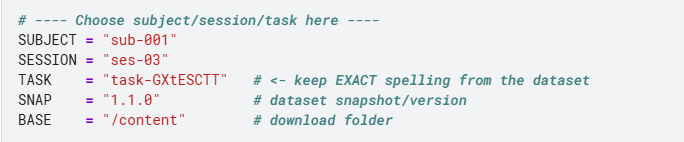

then we download the 3 key files (.set/.fdt/.json)
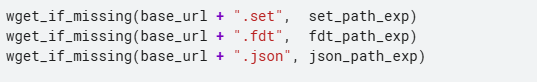

then we verify and match the files using "glob" to auto find filenames in case of spelling errors. and ensure all 3 required files exist before moving on 
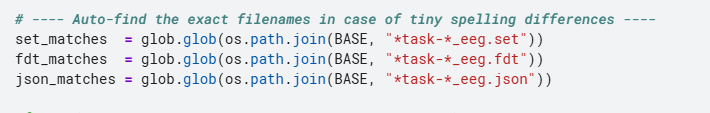

Read the JSON metdata (which helps understand how the recording was setup)
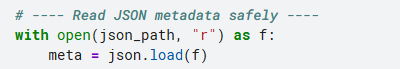

Load EEG into MNE
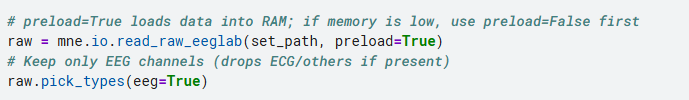
- this loads the EEG using .set (MNE automatically links .fdt)
- setting preload to true will load everything into RAM
- raw pick types will drop other signals like ECG, EOG and keep EEG


then we print metadata (channels, sampling rate, recording length)
plot EEG traces to check data quality. 

In [5]:
# =========================
# Colab EEG loader (OpenNeuro ds003670)
# =========================
# What it does:
# 1) Downloads .set/.fdt/.json for the chosen subject/session
# 2) Lists files to verify names
# 3) Safely opens the JSON metadata
# 4) Loads EEG (.set uses .fdt automatically) and keeps EEG channels only
# 5) Prints info; optional quick plot

import os, glob, json, re, subprocess, sys

# ---- Choose subject/session/task here ----
SUBJECT = "sub-001"
SESSION = "ses-03"
TASK    = "task-GXtESCTT"   # <- keep EXACT spelling from the dataset
SNAP    = "1.1.0"           # dataset snapshot/version
BASE    = "/content"        # download folder

# Compose urls (S3 mirrors used by OpenNeuro)
base_url = f"https://s3.amazonaws.com/openneuro.org/ds003670/{SUBJECT}/{SESSION}/eeg/{SUBJECT}_{SESSION}_{TASK}_eeg"

# Ensure folder exists
os.makedirs(BASE, exist_ok=True)

# ---- Download files (skip if already present) ----
def wget_if_missing(url, out_path):
    if not os.path.exists(out_path):
        print(f"Downloading: {os.path.basename(out_path)}")
        # -q for quiet; remove -q if you want progress output
        code = subprocess.call(["wget", "-q", url, "-O", out_path])
        if code != 0 or (not os.path.exists(out_path)):
            print(f"wget failed for {url}. Trying OpenNeuro non-S3 URL…")
            # Try OpenNeuro direct URL
            # colons must remain in URL path segments for their API
            fn = os.path.basename(out_path)
            # convert name to the colon-separated format OpenNeuro expects
            colon_name = fn.replace("_", ":").replace(":eeg.", ":eeg.")
            alt_url = f"https://openneuro.org/crn/datasets/ds003670/snapshots/{SNAP}/files/{colon_name}"
            code2 = subprocess.call(["wget", "-q", alt_url, "-O", out_path])
            if code2 != 0 or (not os.path.exists(out_path)):
                raise RuntimeError(f"Failed to download {fn} from both URLs.")
    else:
        print(f"Found existing: {os.path.basename(out_path)}")

set_path_exp  = os.path.join(BASE, f"{SUBJECT}_{SESSION}_{TASK}_eeg.set")
fdt_path_exp  = os.path.join(BASE, f"{SUBJECT}_{SESSION}_{TASK}_eeg.fdt")
json_path_exp = os.path.join(BASE, f"{SUBJECT}_{SESSION}_{TASK}_eeg.json")

wget_if_missing(base_url + ".set",  set_path_exp)
wget_if_missing(base_url + ".fdt",  fdt_path_exp)
wget_if_missing(base_url + ".json", json_path_exp)

# ---- List what's actually there (helps catch typos) ----
print("\nFiles in /content:")
subprocess.call(["bash", "-lc", f"ls -lah {BASE} | sed -n '1,200p'"])

# ---- Auto-find the exact filenames in case of tiny spelling differences ----
set_matches  = glob.glob(os.path.join(BASE, "*task-*_eeg.set"))
fdt_matches  = glob.glob(os.path.join(BASE, "*task-*_eeg.fdt"))
json_matches = glob.glob(os.path.join(BASE, "*task-*_eeg.json"))

if not (set_matches and fdt_matches and json_matches):
    raise FileNotFoundError("Could not find all three files (.set/.fdt/.json). Check the listing above.")

set_path  = set_matches[0]
fdt_path  = fdt_matches[0]
json_path = json_matches[0]

print("\nResolved paths:")
print("SET :", set_path)
print("FDT :", fdt_path)
print("JSON:", json_path)

# ---- Read JSON metadata safely ----
with open(json_path, "r") as f:
    meta = json.load(f)

print("\nJSON keys (first 15):", list(meta.keys())[:15])
# Optional: parse the artefact description if present
aString = meta.get("SubjectArtefactDescription", "")
if aString:
    parts = re.split(r":|\t", aString)
    print("\nParsed SubjectArtefactDescription parts:")
    print(parts)

# ---- Load EEG with MNE (EEG-only) ----
try:
    import mne
except ImportError:
    # Install mne if missing (internet must be ON)
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "mne"])
    import mne

# preload=True loads data into RAM; if memory is low, use preload=False first
raw = mne.io.read_raw_eeglab(set_path, preload=True)
# Keep only EEG channels (drops ECG/others if present)
raw.pick_types(eeg=True)

print("\nMNE Raw info:")
print(raw.info)

# ---- Optional quick visualization (uncomment if you want) ----
# %matplotlib inline
# raw.plot(n_channels=32, duration=5.0)  # quick look at first seconds
# mne.viz.plot_raw_psd(raw, fmax=60)

print("\n. You can now proceed with filtering, epoching, feature extraction, and ML.")


Downloading: sub-001_ses-03_task-GXtESCTT_eeg.set
Downloading: sub-001_ses-03_task-GXtESCTT_eeg.fdt
Downloading: sub-001_ses-03_task-GXtESCTT_eeg.json

Files in /content:
total 1.2G
drwxr-xr-x 1 root root 4.0K Sep 15 06:09 .
drwxr-xr-x 1 root root 4.0K Sep 15 06:07 ..
drwxr-xr-x 4 root root 4.0K Jun 26 13:34 .config
drwxr-xr-x 1 root root 4.0K Jun 26 13:35 sample_data
-rw-r--r-- 1 root root 1.2G Jul 10  2021 sub-001_ses-03_task-GXtESCTT_eeg.fdt
-rw-r--r-- 1 root root  893 Jul 10  2021 sub-001_ses-03_task-GXtESCTT_eeg.json
-rw-r--r-- 1 root root  66M Jul 10  2021 sub-001_ses-03_task-GXtESCTT_eeg.set

Resolved paths:
SET : /content/sub-001_ses-03_task-GXtESCTT_eeg.set
FDT : /content/sub-001_ses-03_task-GXtESCTT_eeg.fdt
JSON: /content/sub-001_ses-03_task-GXtESCTT_eeg.json

JSON keys (first 15): ['InstitutionAddress', 'InstitutionName', 'InstitutionalDepartmentName', 'PowerLineFrequency', 'ManufacturersModelName', 'TaskName', 'EEGReference', 'EEGChannelCount', 'ECGChannelCount', 'EOGChanne

/tmp/ipykernel_36/20506446.py:96: RuntimeWarning: Estimated head radius (0.0 cm) is below the 3rd percentile for infant head size. Check if the montage_units argument is correct (the default is "mm", but your channel positions may be in different units).
  raw = mne.io.read_raw_eeglab(set_path, preload=True)


Reading 0 ... 8529989  =      0.000 ...  4264.994 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).

MNE Raw info:
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fpz, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, M1, T7, ...
 chs: 35 EEG
 custom_ref_applied: False
 dig: 38 items (3 Cardinal, 35 EEG)
 highpass: 0.0 Hz
 lowpass: 1000.0 Hz
 meas_date: unspecified
 nchan: 35
 projs: []
 sfreq: 2000.0 Hz
>

. You can now proceed with filtering, epoching, feature extraction, and ML.


In [6]:
#how  many eeg channels do we have?
print("Total channels:", len(raw.ch_names))
print(raw.ch_names)

Total channels: 35
['Fp1', 'Fpz', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'Cz', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'Pz', 'P4', 'P8', 'POz', 'O1', 'Oz', 'O2', 'BIP1', 'BIP2', 'RESP1']


- so we have 35 channels but according to the meeting we had with Dr.Farwa we can consider mainly

Fp1, Fp2, F3, F4, Fz, FCz

- Fz and FCz are the most important ones
      - Middle front of the head
      - linked to focus and memory
  
- F3 is more involved in verbal working memory
    - left front of the head
- F4 is more involved in spatial/visual working memory
    - right front of the head
- Fp1 and Fp2 might be prone to movement artifacts
    - front by the eyes
    - not brain signals

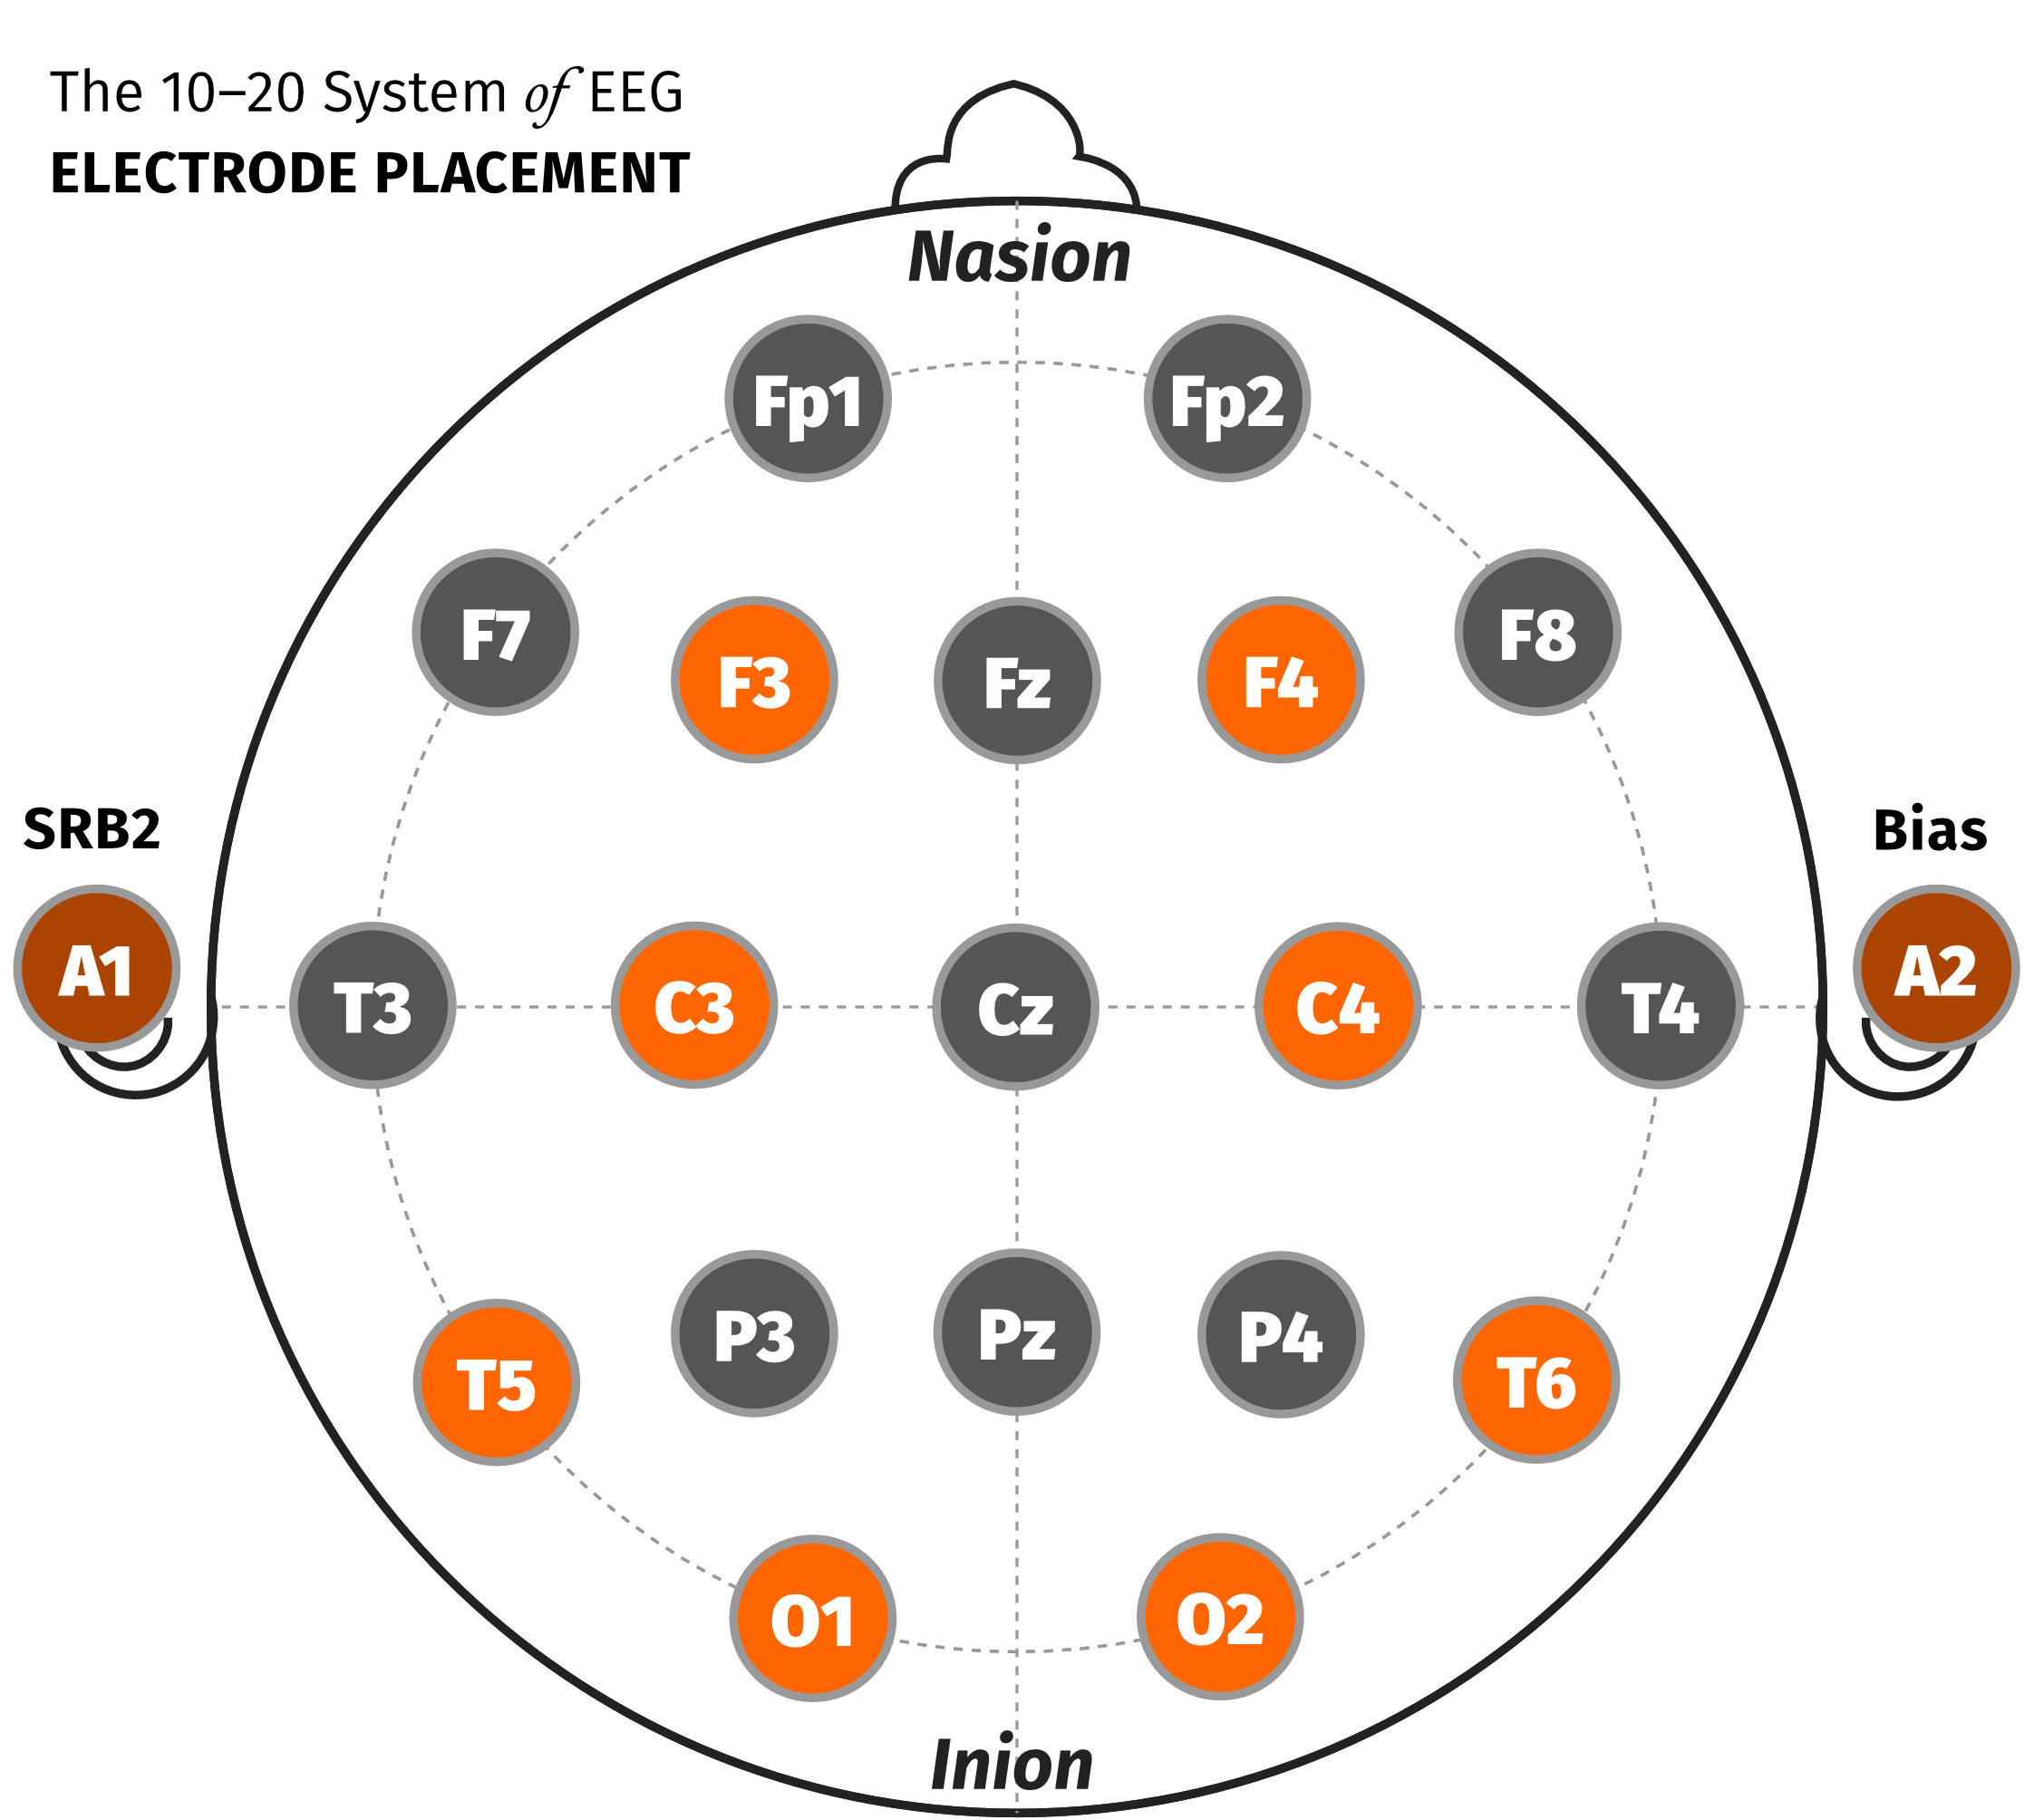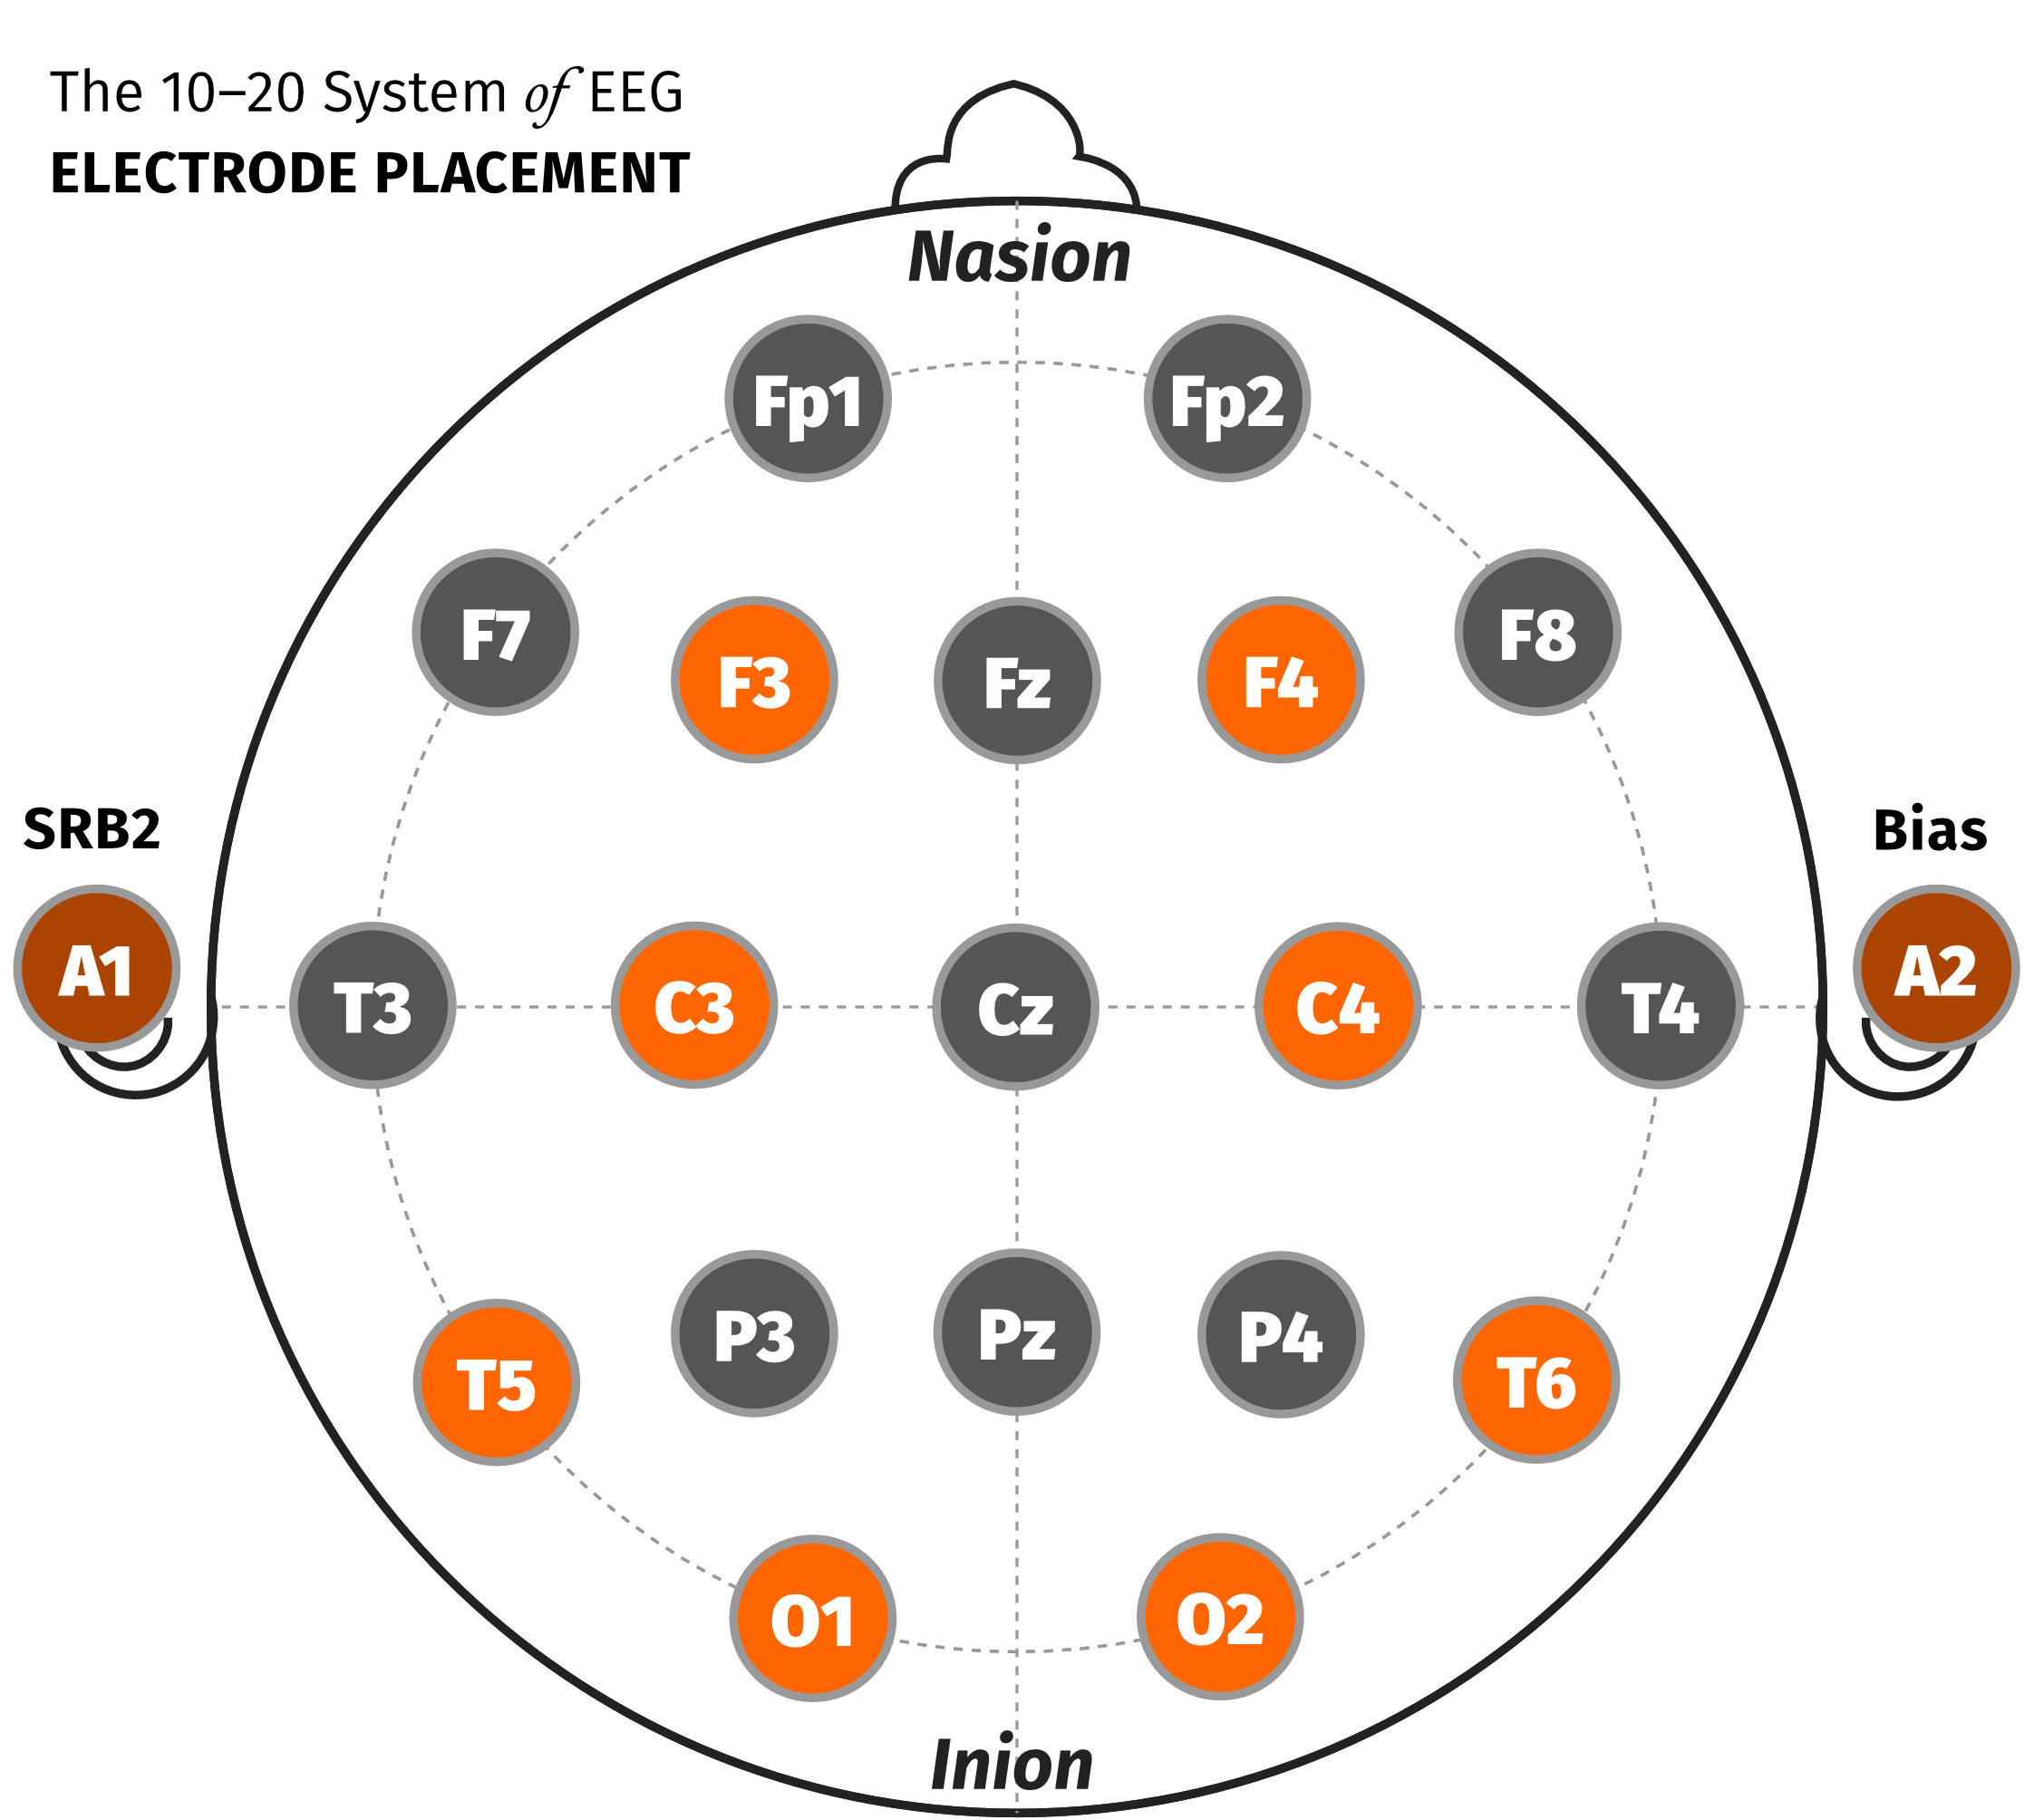

## plotting .set file data from MNE

__MNE__ scaling tells the plot function how tall to draw the signals ( vertical amplitude)
- values are given in volts per unit on the plot
- eeg=150e-6 means 150 microvolts corresponds to one unit of vertical scale in the plot
- EEG brain signals have amplitudes in the range 10-100
- by setting it to the above range you make sure the typical EEG activity fits on the plot without looking squashed and clipping out of range
- a smaller value will make the traces look bigger
- a larger value will make the traces look flatter

Using matplotlib as 2D backend.


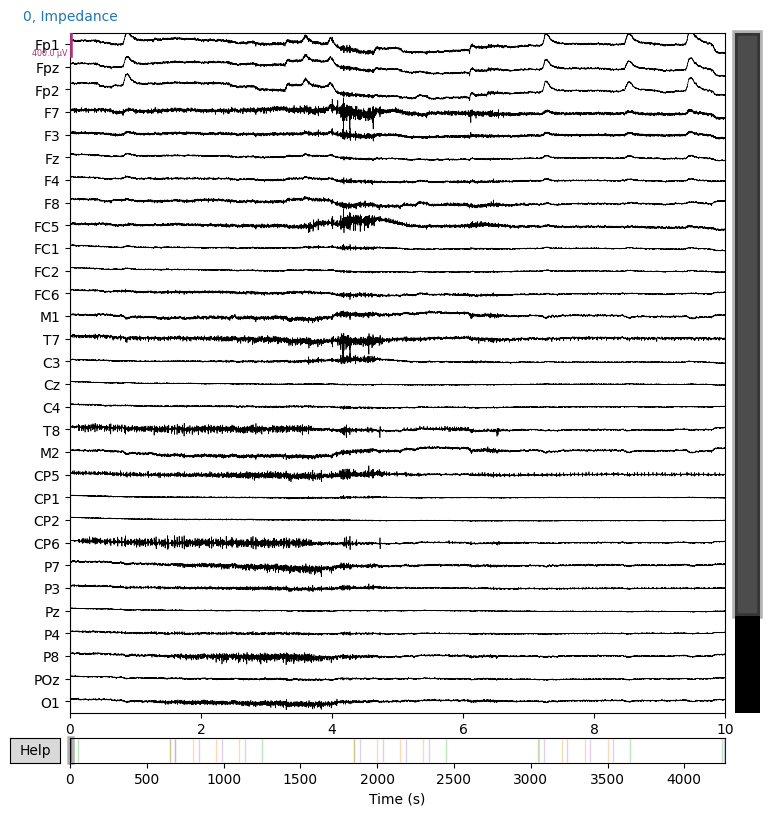

In [7]:
#plot the data using MNE methods

#set some of the scaling to see all the channels
scaling_dict = dict(eeg=20e-5) 

raw.plot(n_channels=30, duration=10, scalings = scaling_dict);
#plot all EEG channels

- __scaling_dict__: sets the vertical amplitude scale (so signals are neither too squashed nor too flat).
- __n_channels=30__: plots 30 EEG channels at once.
- __duration=10__: shows a 10-second time window of data.

__what does this plot show ( EEG signals)?__

- Each row = one EEG channel 

- X axis = time in seconds 

- Y axis = EEG voltage scaled == microvolts

- the brainwave signals with different patterns depending on electrode location

- the bottom row colored event markers are task events recorded in the experiment
    - these task events can be natural osciilations, eye blinks and possible noise .
 
- the long bar at the bottom is the timeline overview of entire recording 4000 seconds
      - it compresses the whole session into a tiny strip

## Types of EEG activity shown
 __Delta Rhythm__ (0.5 - 4 Hz )
- frontal Channels Fp1/ Fpz/ Fp2  show large peaks likely eye blinks
    - This means sleep, deep rest
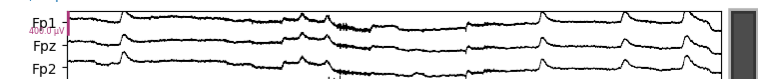

__Theta Rythm__ (4 - 7 Hz)

- frontal (Fz, FC1, FC2) central areas
    - Drowsiness, memory, learning

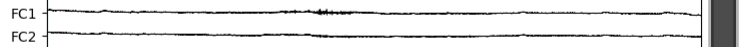

__Alpha Ryhtm__ ( 8 - 12 Hz)

- Occipital (O1, O2, Pz, POz, P3, P4)
      - relaxation, eyes closed
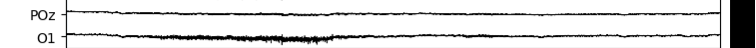
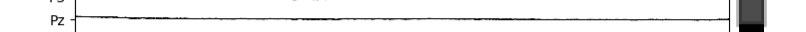





__Beta Rhythm__ (13 - 30 Hz)

- Frontal (F3, F4, F7, F8, Fpz) and Central (C3, Cz, C4)
    - Active thinking, motor activity , focus

__Gamma Rhythm__ ( > 30 Hz - 100 Hz)

- Distributed, strongest sensory and frontal regions
      - Higher cognition, perception, bidning of information

__Theta and  Beta/gamma Rhythms__
- Temporal Channels (T7,T8) show muscle activity maybe in jaw or neck areas which are fast and spiky.
  - these are not real brain signals
    




  

  

## WHY IS THIS IMPORTANT?

we need to know how to tell apart true EEG activity from artefacts so we dont trigger stimulation on noise

we know which rythms appear in which brain regions to help us decide what features to monitor during experiment 1. 

## plotting .set file data in other libraries__

we pull out data imported from MNE and we plot them using Matplotlib and plotly

**this is about zooming into one channel and plotting it alone**

Text(0.5, 1.0, 'Plotting EEG Channel FP1')

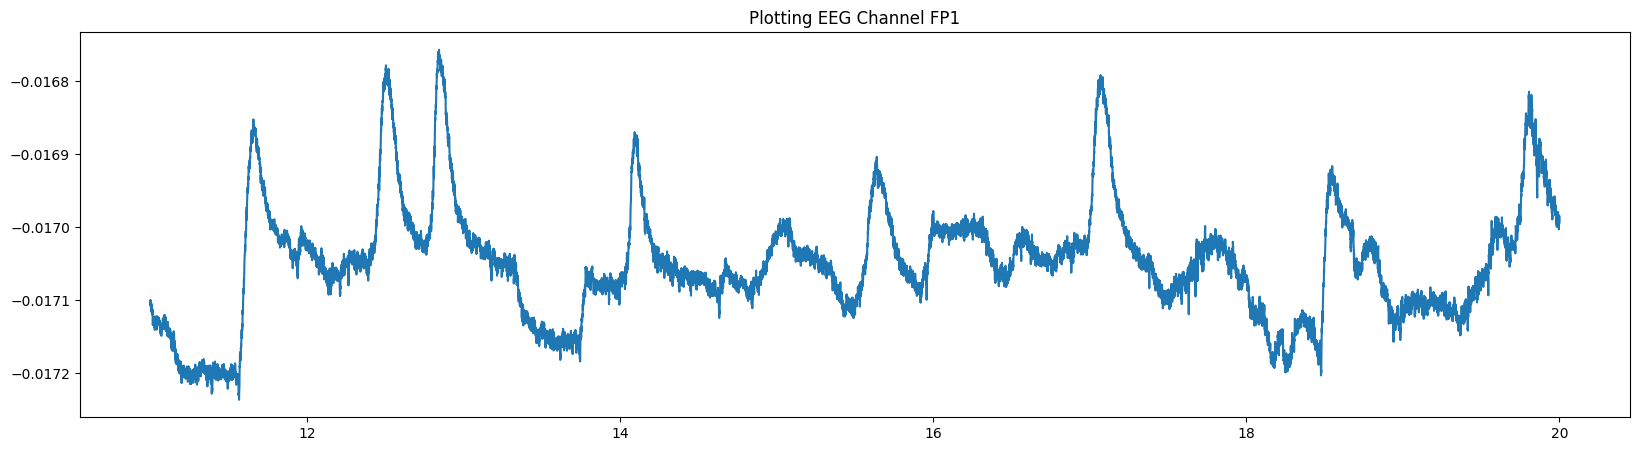

In [8]:
#code from here:

#gets the sampling rate of EEG recording (2000 Hz samples per second)
sampling_freq = raw.info["sfreq"]

#choose time window for 11 and 20 seconds of recording
#multiply by sampling frequency converts seconds to sample indices (22000 samples, 20 seconds -> 40000 samples)
start_stop_seconds = np.array([11,20])
start_sample, stop_sample = (start_stop_seconds * sampling_freq).astype(int)

#pick a channel 
#0 means the first channel in your list 
channel_index = 0 #channel FP1 in previous plot

#extract the data - pull out the EEG values for FP1 betweem 11s and 20s which gives us a tuple
raw_selection = raw[channel_index, start_sample:stop_sample]

#print(raw_selection)
# separate x and y for plotting 
x = raw_selection[1] #time values in seconds
y = raw_selection[0].T #EEG voltage values 

#plot with matplotlib
plt.figure(figsize=(20,5))
plt.plot(x,y)
plt.title("Plotting EEG Channel FP1")

Here we extracted FP1 between 11–20 seconds and plotted it manually. 

This lets us zoom into one channel, which is helpful when we want to check artefacts, or later when we compute features like mean amplitude or frequency power.

Using Plotly also makes it interactive, so we can explore signals more flexibly than the MNE viewer

- the large slow peaks are mostly eye blinks or movement artefacts because FP1 is right above the left eye.

- this isnt clean brain rythm like alpha or beta. its mainly noise from eyes

. 

In [9]:
#use plotly to look at channels data 
import plotly.express as px
from plotly import graph_objs as go 

px.line(x=x, y=y[:,0].T, title = "plotting Channel FP1")

the peaks (sharp upward bumps) are eyeblinks or movement artefacts not pure brain activity. 

this diagram uses plotly plot
    - interactive rather than using matplotlib
    - good for exploring signals live during preprocessing or debugging. 


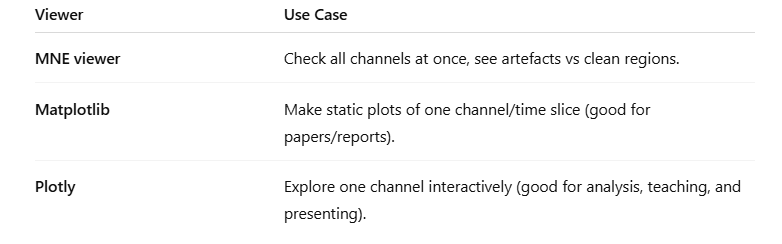